# A simple Product Recommendation process based on product descriptions

### Goal of the project

Given an amazon product description, I'm trying to see how what products will be 'recommended'. For example, if I'm purchasing a Banana Republic t-shirt, I want to see if the recommendation system just recommends other t-shirts or/and other Banana Republic products. Once we have the results, I'll first visually inspect the results and then analyze results (recommendations in this case) based on the descriptions.

### Motivation for this project and practical application

Any decent recommender model would have been trained using data from millions of products. For companies like Amazon, such large amounts of data is easy to come by. But that's not all now is it? Can the same recommender model be used for years at a stretch without any modifications? Probably not. Products evolve over time. Companies do away with older products and bring in  newer ones every day. Companies like Amazon have the time and resources to ensure that their recommendation systems are up to date with the latest trends.

Moreover, neural networks are being used for recommender systems. These models are designed using sophisticated state of the art architecture. The model needs to be designed first. Then it will be tested and modified again and again. Fine tuning deep learning models can be a monumental task. Now, what if I told you that we could come up with a decent recommender process that involves no training at all? Sounds too good to be true? Well, thanks to __[Google's universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ , this is possible! Given a product description as text, the input will be mapped to a high dimensional vector of length 512. These "embeddings" are then used to compute similarities based on which practical recommendations can be made

### Concept before deep dive

Please refer to this __[jupyter notebook](https://github.com/adjakka/Springboard_Capstone_Projects/blob/master/Capstone_2/notebooks/Concepts_explained.ipynb)__ for a simple breakdown of some of the concepts, inner workings of embeddings ans how they contribute to developing semantic relationships between words/sentences.

### A brief introduction to the Universal Sentence Encoder

This encoder encodes words, phrases, sentences or even paragraphs into high dimensional space. This model was trained extensively using various data sources to accomlish various NLP (Natural Language Processing tasks). 

The input word, phrase, or sentence is converted to a vector of size 512. This vector is represented though a numpy array. What's so special about this encoder is that it maintains context similarity in a semantic sense which can be very useful. For ex, we have the three sentences:

1) How old are you?
2) How are you?
3) What is your age

We know that sentences 1 and 3 are closer in a semantic sense. While sentences 1 and 2 differ only a word, they differ greatly in contrast. The universal sentence encoder was trained such that we compute any mathematical similarity between the 3 sentences, sentences 1 and 3 will be closer than 1 and 2. That's incredible isn't it?

For this project, I'll be using the __[universal-sentence-encoder-large](https://tfhub.dev/google/universal-sentence-encoder-large/3)__. This model was trained with a transformer encoder. We can hope to achive a high accuracy with this model but the tradeoff would be the computing time and memory usage. A lighter version of the universal sentence encoder can be found __[here](https://tfhub.dev/google/universal-sentence-encoder/2)__

### Outline of the steps in this file:

- Convert the descriptions column to a list and have that run through __[Tensorflow's Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ . This computes a numpy array of length 512 for each movie plot.
2. Calculate the cosine similarities matrix using the above generated numpy array for the 9 most similar product descriptions.
3. Plot the images of the products using the url in the source file.
4. Analyze genres and possibly the plot descriptions as well.

In [1]:
import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

### STEP 1

In [2]:
#Reading the data file
new_df = pd.read_csv('home_kitchen.csv')

In [4]:
#Inspecting the structure of the file
new_df.head()

imUrl  \
0  http://ecx.images-amazon.com/images/I/41MXBRGC...   
1  http://ecx.images-amazon.com/images/I/41tRnWfb...   
2  http://ecx.images-amazon.com/images/I/31ummNI9...   
3  http://ecx.images-amazon.com/images/I/41C94YPJ...   
4  http://ecx.images-amazon.com/images/I/41q3F3CQ...   

                                               title  \
0  Johnson Brothers Friendly Village 8-Inch Veget...   
1  SHARP Plasmacluster Air Ionizer IG-CM1 B Black...   
2  Noritake Colorwave Floral Bowl, 4-Inch, Chocol...   
3             Riedel Vinum Spirits Glasses, Set of 2   
4  Make My Day 9-1/2-Ounce Ceramic Hot Beverage C...   

                                         description  \
0  Friendly Village by Johnson Brothers, introduc...   
1  Sharp's exclusive and highly esteemed Plasmacl...   
2  Colorwave Chocolate has a matte-textured, deep...   
3  Renowned Austrian glassmaker Riedel designs th...   
4  Enjoy your daily fix of coffee or tea in style...   

                                     description_new  
0  Friendly Village by Johnson Brothers introduce...  
1  Sharp's exclusive and highly esteemed Plasmacl...  
2  Colorwave Chocolate has a matte textured deep ...  
3  Renowned Austrian glassmaker Riedel designs th...  
4  Enjoy your daily fix of coffee or tea in style...

In [5]:
len(new_df)

76384

We will now only choose the fields of interest

In [6]:
new_df = new_df.dropna()

In [7]:
len(new_df)

75336

In [8]:
new_df = new_df.reset_index(drop=True)

In [9]:
len(new_df)

75336

In [70]:
new_df.to_csv('home_kitchen.csv')

The index will be reset by ignoring the old indices.

### STEP 2

Now, the 'description' column will be transformed using the TF-IDF vectorizer and english stop words. (Common non-descriptive/non-adjective words 'a', 'and' and 'the' will be ignored. 

In [10]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [11]:
#Download thee required module
embed = hub.Module(module_url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/3'.
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 230.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 470.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/3: 730.00MB
INFO:tensorflow:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/3, Total size: 810.60MB
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/3'.


In [12]:
#All the product descriptions have been appended to a list
all_descriptions = new_df['description_new'].tolist()

In [13]:
len(all_descriptions)

75336

In [14]:
#Oddly enough, I'm running out of memory when running the sentence encoder for the full file. Hence, I'm breaking up the data into chunks of 10000.
set_1 = all_descriptions[:10000]
set_2 = all_descriptions[10000:20000]
set_3 = all_descriptions[20000:30000]
set_4 = all_descriptions[30000:40000]
set_5 = all_descriptions[40000:50000]
set_6 = all_descriptions[50000:60000]
set_7 = all_descriptions[60000:70000]
#I've only selected 70K product descriptions due to meory contraints when calculating the cosine similarites.

#The lists have been appended to another 'master list'. Each sublist will be read one at a time from the master list. Once a
#sublist is read, the sentence embeddings are generated and the numpy array is stored locally. 
final_set = [set_1, set_2, set_3, set_4, set_5, set_6, set_7]

In [15]:
tf.logging.set_verbosity(tf.logging.ERROR)
j = 0 # This variable will be used for naming convention of the files.
for i in final_set:
    j+=1 # Each time a sublist is read from full_set(our master list), this variable is incremented by 1
    with tf.device('/device:CPU:0'): # This module doesn't seem to be working with GPUs and I run into errors. Could be because I'm using the traditional Tesla K80 GPUs
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            description_embeddings  =  session.run(embed(i)) #Sentence embeddings are generated
            np.save('kitchen_home_set' + str(j) + '.npy', description_embeddings) #Embeddings are saved locally.        

In [10]:
#The locally generate sentence embeddings are now read
kitchen_embed_set_1 = np.load('kitchen_home_set1.npy')
kitchen_embed_set_2 = np.load('kitchen_home_set2.npy')
kitchen_embed_set_3 = np.load('kitchen_home_set3.npy')
kitchen_embed_set_4 = np.load('kitchen_home_set4.npy')
kitchen_embed_set_5 = np.load('kitchen_home_set5.npy')
kitchen_embed_set_6 = np.load('kitchen_home_set6.npy')
kitchen_embed_set_7 = np.load('kitchen_home_set7.npy')

In [11]:
#Concatenating the numpy arrays into a single numpy array which will allow us to leverage indexing
full_set = np.concatenate([kitchen_embed_set_1, kitchen_embed_set_2, kitchen_embed_set_3, kitchen_embed_set_4, kitchen_embed_set_5, kitchen_embed_set_6, kitchen_embed_set_7])

In [12]:
len(full_set)

70000

### STEP 4

In this step, the relative cosine similarities matrix will be computed. For two duplicate images, the computed cosine similarity is 1. If the images are vastly different from one another, the similarity coefficient will be close to 0. Now, the cosine similarity matrix for just the first three images.

Before we dig deep, let's look at the cosine similarities matrix for just the first 3 products.

In [16]:
cosine_similarity(description_embeddings[:3])

array([[1.0000002 , 0.17464985, 0.3760876 ],
       [0.17464985, 1.0000002 , 0.12441635],
       [0.3760876 , 0.12441635, 0.9999997 ]], dtype=float32)

We get a square matrix. The cosine similarity of an element with itself is 1. Hence, higher the cosine similarity, higher the semantic relationship between the descriptions.

In [13]:
description_embeddings = full_set

In [14]:
cos_matrix = cosine_similarity(description_embeddings)

In [15]:
cos_matrix.shape

(70000, 70000)

Next, we'll compute the cosine similarities of all the products in our dataset.

We get a square matrix of size 70000x70000.

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [24]:
#This function will read the url of the image, read the image usinf cv2, and convert it to a numpy array
def get_images(url):          
    resp = urllib.request.urlopen(url)                        # This step read the image from the url
    image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #new_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
    return image

In [25]:
#This function will be used to get the 9 most similar products. This "ranking" will be defined using the generated cosine similarities matrix.
def get_related_products(index_num, data = new_df):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    similar_prod_arr = cos_matrix[index_num].argsort()[::-1][:10] # Computes the 9 closes product descriptions based on cosin similarity matrix.
    prod_url = new_df['imUrl'].loc[index_num] # Obtaining the URL of the product image
    prod_img = get_images(prod_url) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(19,14))
    plt.subplot(4,3,2)
    plt.imshow(prod_img) # Plotting the product image
    plt.title('Product Image',fontsize=14, fontweight='bold')
    plt.xticks([]) # X axis will have no labels
    plt.yticks([]) # Y axis will have no labels
    for i in similar_prod_arr[1:]:
        url = new_df['imUrl'].loc[i] # Retrieving the image URLs of all relatd products.
        img = get_images(url) # Retrieves the images of all items related to the product
        plt.subplot(4,3,j) 
        plt.imshow(img) # Plots the images
        plt.xlabel('Related product index: ' + str(i))
        plt.xticks([])
        plt.yticks([])
        j+=1

### STEP 6

Let's get started with the fun part already!

Before we begin seeing results right away, let us inspect th product in query.

I've added code to display the index number of related products which will allow us to easily locate and inspect them.

In [10]:
new_df['title'].loc[32298]

'Optimus H-8010 Infrared Quartz Heater with Remote Control'

In [9]:
new_df['description_new'].loc[32298]

'Optimus brings you the finest in fans and heaters. The H 8010 is an infrared quartz heater in a furniture grade wood cabinet. Features include a wheel base for easy movement two heat settings of 1000 and 1500 Watt automatic thermostat control overheat thermal cut off  and a 0 to 12 hour timer. Comes with a remote control.'

What we have here is a remote controlled heater. The first image represents the product image and the 9 images below this image are the related/recommended products.

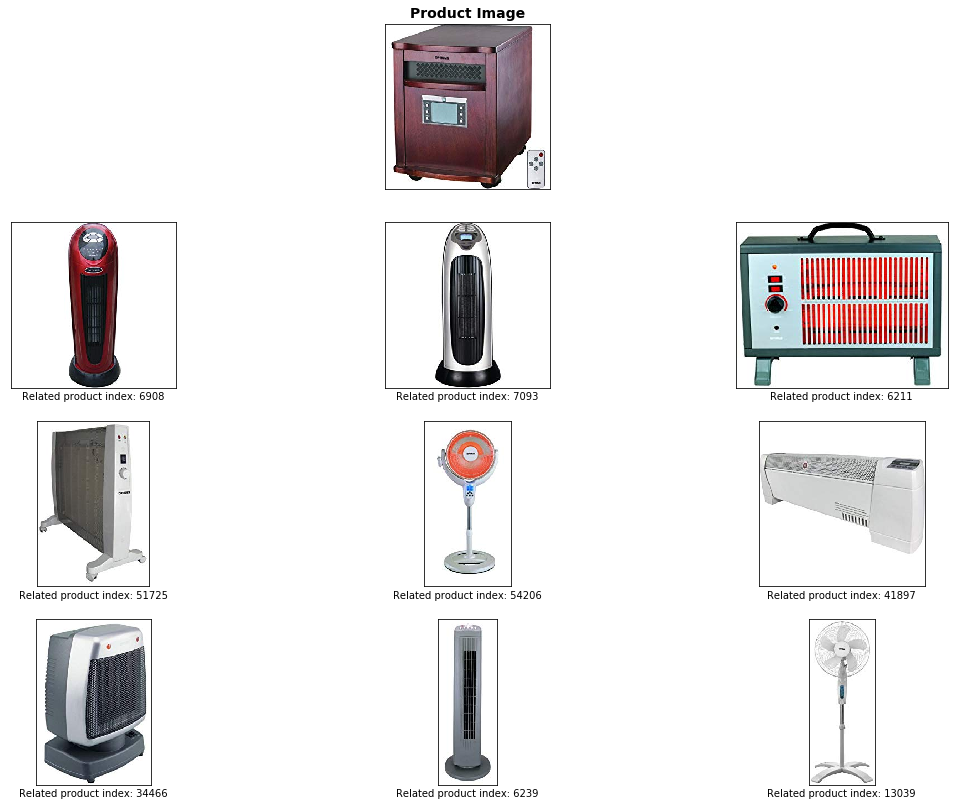

In [30]:
get_related_products(32298)

In [15]:
nums = [6908, 6211, 51725, 54206, 41897, 34466, 6239, 13039]

In [16]:
for j in nums:
    print(str(j) + ' ' + new_df['title'].loc[j] + '\n')

6908 Optimus H-7328 Portable 22-Inch Oscillating Tower Heater with Digital Temperature Readout and Remote Control

6211 Optimus H-2200 Portable Fan-Forced Radiant Heater with Thermostat

51725 Optimus H-8408 Portable Micathermic Flat-Panel Heater

54206 Optimus H-4500 14-Inch Oscillating Pedestal Digital Dish Heater with Remote

41897 Optimus H-3603 30-Inch Baseboard Convection Heater with Digital Display and Thermostat

34466 Optimus H-7246 Portable Oscillating Ceramic Heater

6239 Optimus F-7327 30-Inch Tall 3-Speed Tower Fan

13039 Optimus F-1760 16-Inch Wave Oscillating 3-Speed Stand Fan with Remote Control, White



Apart from the obvious results, we have a tower fan(6239) and a regular stand fan (13039). These aren't heaters. Let's check out product descriptions to see what they say and may be we can make sense of why they showed up?

In [18]:
nums = [6239, 13039]

In [19]:
for j in nums:
    print(str(j) + ' ' + new_df['description'].loc[j] + '\n')

6239 Optimus 30 Inch tower fan includes 4 position push button switch for off, lo, med and hi speeds. Rotary switch with up to 2 hours timer included. Fan enables wide air coverage provided by a 70 degree oscillation. Design is space saving and provides powerful air circulation. Includes convenient carrying handle. Assembly is easy and requires no tools.

13039 Optimus 16 inch wave oscillating stand fan includes microprocessor based remote control function including on/off, 3 speed selection and 1-7 hour timer selection. Also includes 4 position push button switch: Off, Lo, Med and Hi located on the pole of the fan. Provides adjustable tilt and angle head for vertical settings as well as adjustable pole height. Base of the fan is a cross design for extra stability. Provides full room 90-degree oscillation with up/down and left right wave oscillation for excellent coverage. No tool assembly required and the powder coated safety grill is easily removable for cleaning.



For product with index 13039, it may have showed up because it's remote controlled. But, in general, these two results probably showed up in the context of air circulation. Let's move on!

In [21]:
new_df['title'].loc[35398]

'Sterilite 37208002 2 Drawer Cart White with See-Through Drawers and Black Casters 2-Pack'

In [20]:
new_df['description_new'].loc[35398]

'The 2 drawer ultra drawer carts feature durable and solid sided walls to hide clutter and clear drawer fronts for easy identification of contents. The large drawers are ideal for hanging files. Casters are included with all drawer carts to create mobile storage solutions'

We have drawers here. Let's check out the images of the related products and we'll analyze the results for those products that we didn't expect.

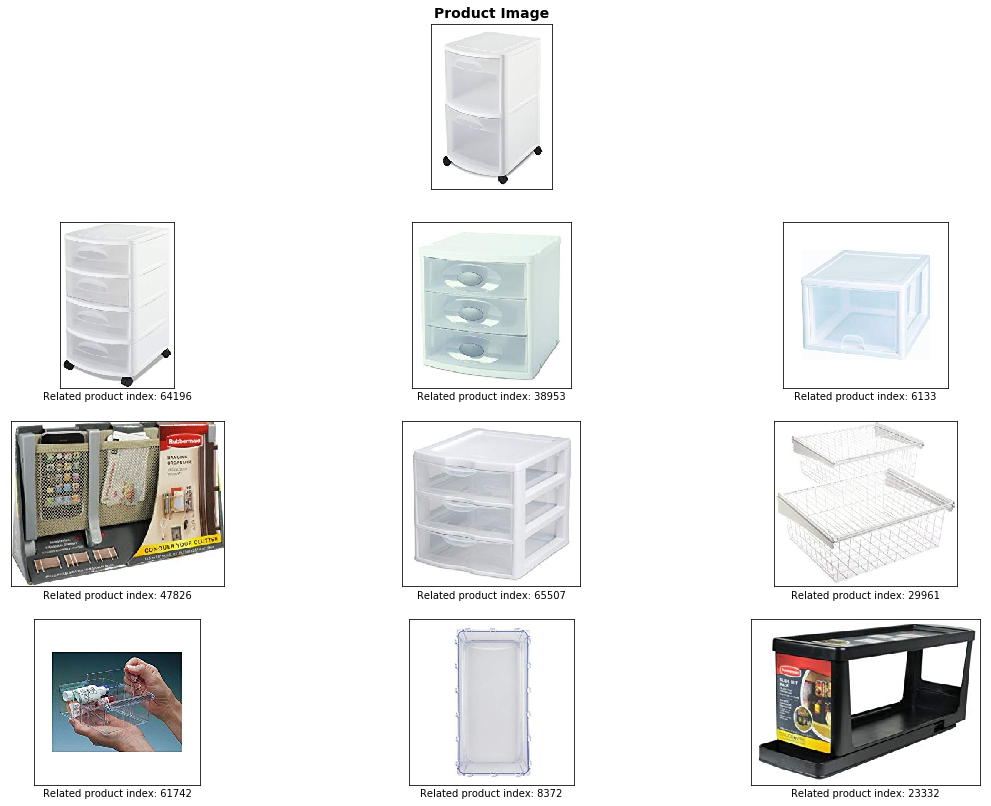

In [44]:
get_related_products(35398)

In [22]:
nums = [47826, 29961, 61742, 8372, 23332]

In [23]:
for j in nums:
    print(str(j) + ' ' + new_df['title'].loc[j] + '\n')

47826 Rubbermaid 1823855  Adjustable Hanging Organizer

29961 ClosetMaid 2814 ShelfTrack 2 Drawer Kit

61742 Stack-On DIV-LG Large Parts Storage Organizer Dividers, 16 Pack

8372 OXO Good Grips Interlocking Deep Drawer Bin, 6-by-12-Inch

23332 Rubbermaid 1780726 Pantry Organization Slide Out 2-Tier Can Rack



Okay,so some of the products are indeed drawers. Product 47826 is in here probably because like drawers, it could be used to store and organize things? 23332 is an interesting result. We got a tin rack! Let's check out it's description!

In [25]:
new_df['description'].loc[23332]

'The rubbermaid 1780726 pantry organization slide out 2-tier can rack creates storage for hard to stack items. You can easily store items like canned food, small boxes, or spices and access them instantly with the slide out shelf. It allows access to any item at any time (unlike gravity feed solutions). The 2-tier rack installs easily with 3 clips and screws.'

After reading the above description, I believe the context here is a "container for organizing things".

In [52]:
new_df['title'].loc[35095]

'WearEver 12-Inch Stir Fry'

In [26]:
new_df['description'].loc[35095]

'WearEver 12-Inch Stir Fry Pan, Metal Safe Nonstick Interior, Metallic Black Exterior'

We have a stir/fry pan here!

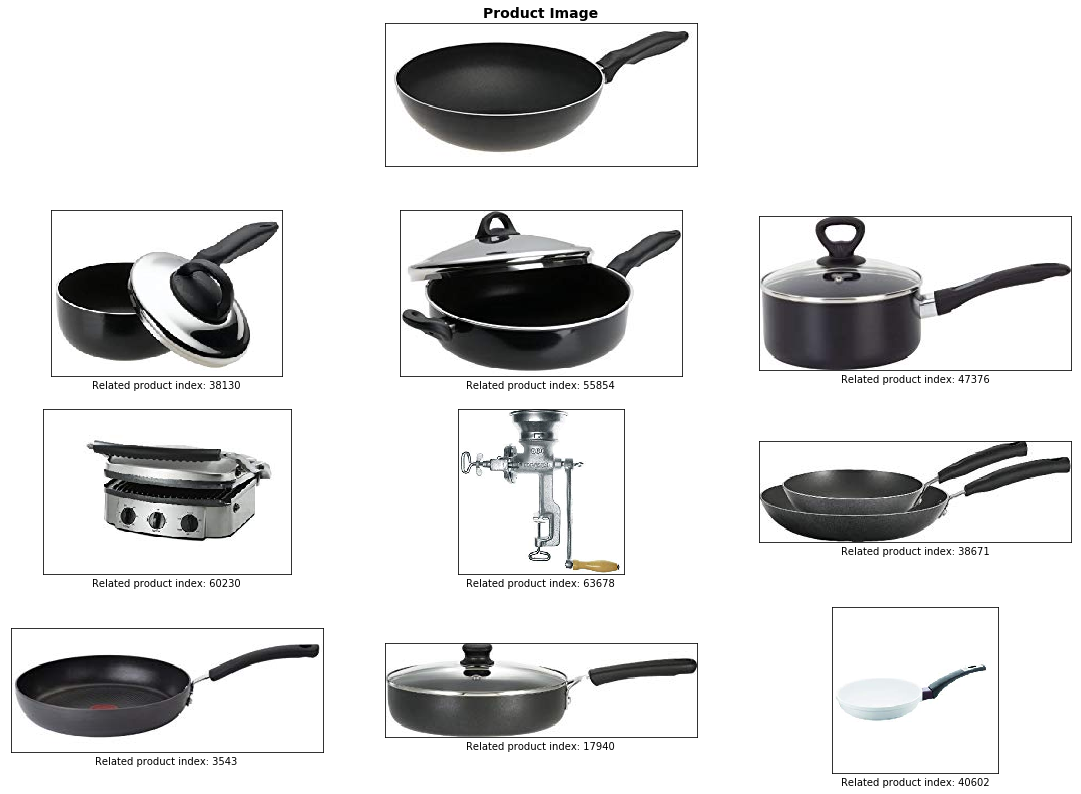

In [53]:
get_related_products(35095)

Ok, so let's check out some of the less obvious results

In [27]:
nums = [60230, 63678]

In [31]:
for j in nums:
    print(str(j) + ' ' + new_df['description'].loc[j] + '\n')

60230 Brushed stainless steel exterior, contact grill, panini, griddle, open grill, floating hinge system, 3 dials, 4 non-stick dishwasher safe removable cooking plates, drip cups to collect grease, 120v / 500w.

63678 Features:  Glass lids with vents.  Mirror polish exterior and satin finish.  Encapsulated base for even heat distribution.  Stay cool hollow handles and knobs.  Interior Dutch oven lid fits fray pan.  5 quart covered Dutch oven.  1 quart covered saucepan.  2 quart covered saucepan.  9 1/2" fry pan.



In [33]:
new_df['title'].loc[63678]

'7 Piece Stainless Steel Cookware Set'

Product 60230 is a grill machine. The product description for 63678 seems a little strange. While 60230 is a relatable result, it looks like we have th wrong url for product 63678.

In [34]:
new_df['title'].loc[5235]

'DEEBOT D77 The 3-D Vacuuming Robot by Ecovacs Robotics, Inc'

We have a robot vacuum here. Let's check out the related products.

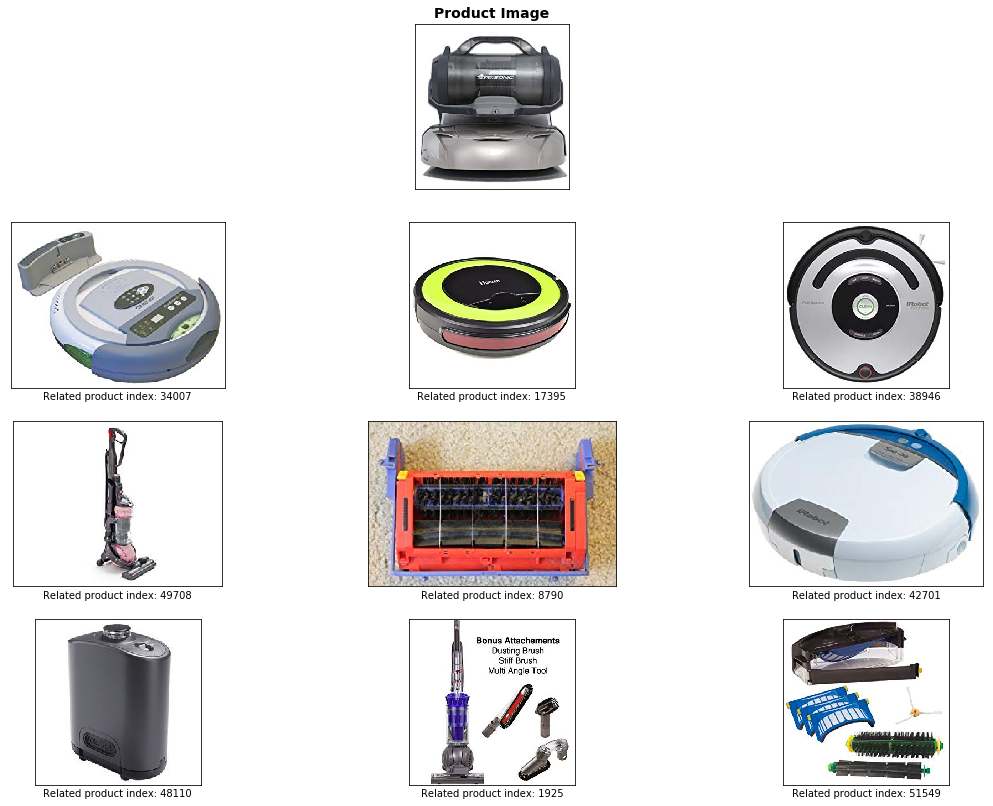

In [55]:
get_related_products(5235)

In [37]:
nums = [48110, 51549]

In [39]:
for j in nums:
    print(str(j) + ' ' + new_df['description'].loc[j] + '\n')

48110 Roomba iRobot auto virtual wall. This item is activated by your Roomba when it begins it's cleaning cycle - no worrying about remembering to turn the wall on! (batteries not included)

51549 The Roomba 500 Series AeroVac upgrade kit makes your Roomba more effective and even more convenient.  The powerful AeroVac bin is the latest breakthrough in cleaning technology.  It maximizes airflow to not only pull additional hair and debris off Roomba's brushes, but also guide debris to the back of the bin, allowing you to empty it less often.



Ok, so product 48110 is indeed a vacuum cleaner. But what;s up with 51549? Vacuum parts for some of the Roomba vacuums (500 series). That was a pretty interesting result, wasn't it?

In [46]:
new_df['title'].loc[35385]

'MaxiMatic EPN-501 Elite Cuisine Electric Panini Grill with Non-Stick, Silver'

In [47]:
new_df['description'].loc[35385]

'The Elite Cuisine Panini Grill & Press allows you to enjoy your favorite grilled foods and make delicious homemade Panini&#x2019;s at any time. The dual sided non-stick grilling surface ensures even cooking and easy clean up. It features LED ready and preheat lights, a floating hinge system with side locking lever for precise uniform grilling and a built-in grease reservoir with a drip catching cup. It&#x2019;s also a perfect space saver with its upright design and cord storage.'

Alright, we've got a grill machine here! Let's see what we get for related products.

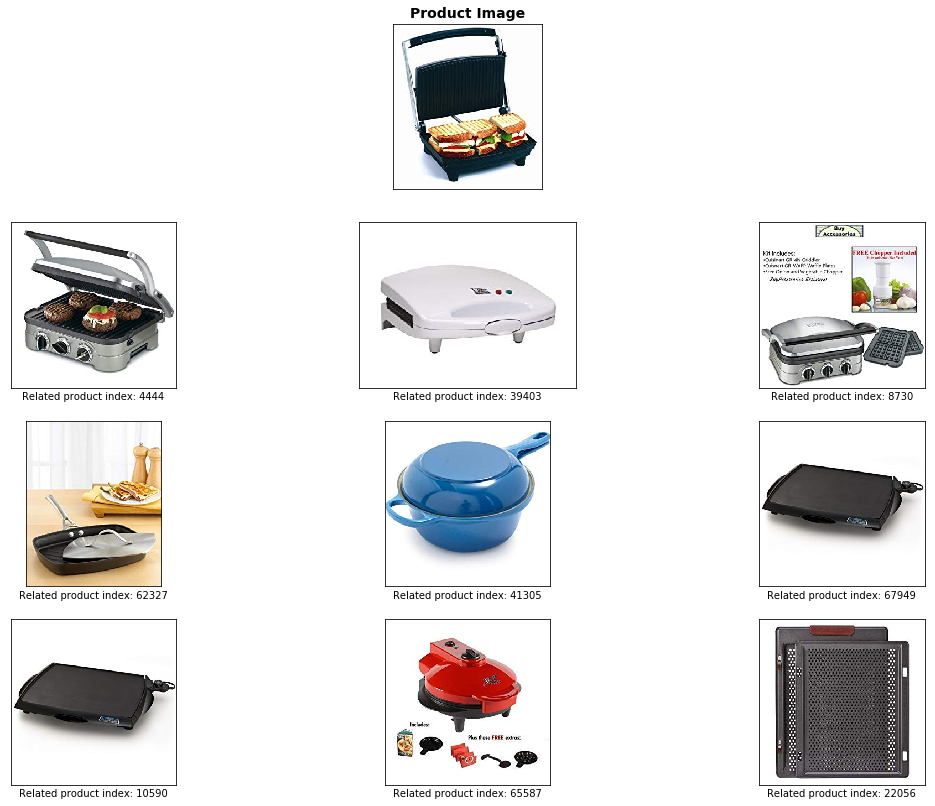

In [62]:
get_related_products(35385)

In [52]:
nums = [41305, 22056]

In [53]:
for j in nums:
    print(str(j) + ' ' + new_df['description'].loc[j] + '\n')

41305 Innovative saucepan features a lid that doubles as a fry pan, so you'll get two Le Creuset pans for one great price. This versatile combo lets you fry up bacon while cooking oatmeal or saut veggies to add to simmering soups. Or simply use the interlocking lid to retain heat and moisture while you cook. Newly updated design features a larger 2-qt. capacity, enhanced ergonomic handles, and a mess-free pouring lip. Space-saving set is perfect for small kitchens or for cooks with overcrowded cabinets. Suitable for all heat sources: electric, gas, ceramic and induction. Dishwasher safe, but hand washing recommended. Enameled cast-iron construction. 2-qt capacity, 8" diameter skillet/lid. Limited lifetime warranty. Made in France,.

22056 Crisper Flipper by KitchenAid for cooking french fries, tater tots, chicken nuggets and other foods in the oven is now easier than ever. This innovative kitchen gadget helps you achieve the perfect crispy texture and golden brown color every time. Equ

Products 41305 and 22056 can be used for the purpose of frying as opposed to grilling. But the context of descriptions here seem to be 'frying' and 'grilling'. 

In [36]:
new_df['title'].loc[19306]

'West Bend 6-Quart Stainless Pressure Cooker'

In [77]:
new_df['title'].loc[8289]

'Deni 9780 Oval-Shaped 8-1/2-Quart Electric Pressure Cooker'

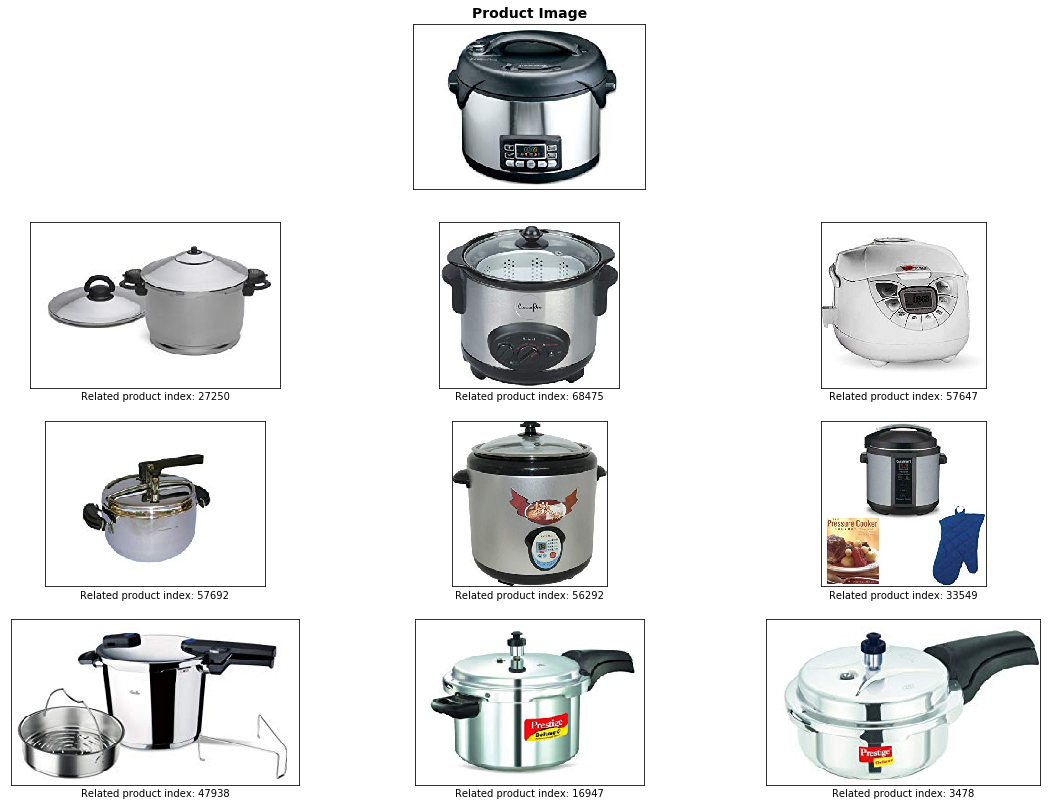

In [78]:
get_related_products(8289)

It'ss quite obvious that we get also get pressure cookers that are used with stoves. But again, it didn't really deviate from "prssure cookers". 

In [56]:
new_df['title'].loc[34142]

'Brita Opti-Max Dispenser'

In [57]:
new_df['description'].loc[34142]

'Treat yourself and your family to the Brita Optimax Water Filtration Dispenser. Holds up to 2 gallons and transforms tap water in minutes. Can eliminate 99% of lead. Can reduce mercury, copper, chlorine, bad tastes and odors, sediments and water hardness. Easy-to-change filter processes up to 40 gallons of water. The dispenser includes a handy filter-change reminder with removable cup for easy reservoir refills. Comfortable handles for easy carrying. 90-day unconditional money-back guarantee. Imported. 9Hx8Wx13-1/2D".'

We have a water dispenser here.

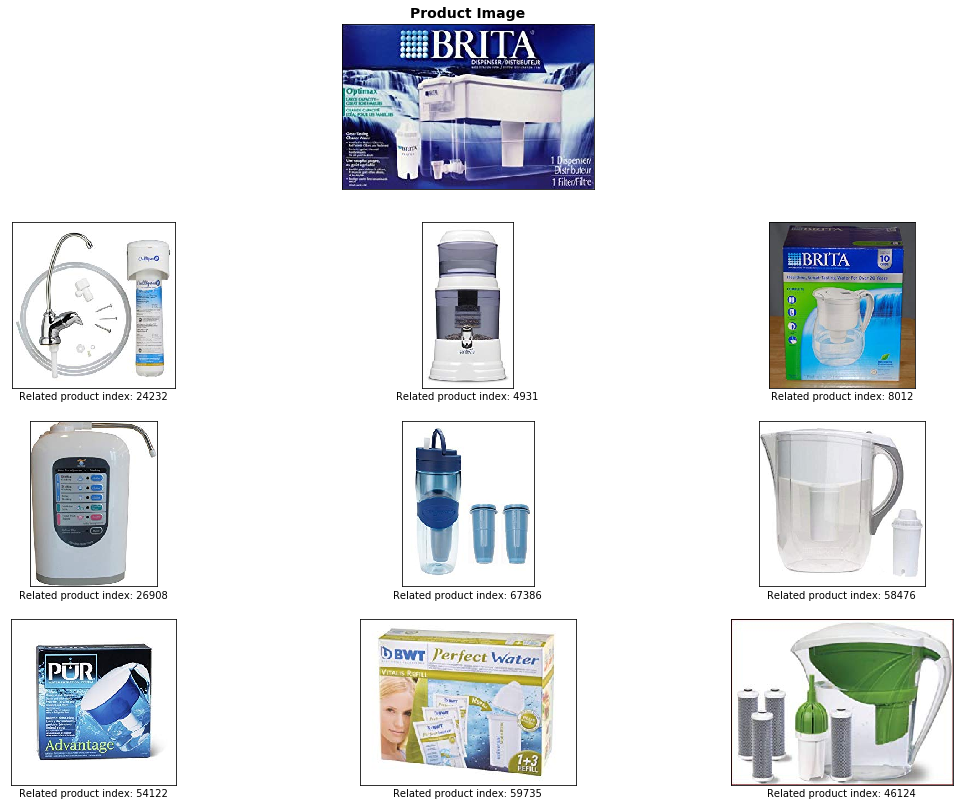

In [87]:
get_related_products(34142)

In [59]:
new_df['title'].loc[59735]

'BWT Water Pitcher Filter Replacement - 1 Filter + 3 Refills with Mg2+'

Look at these great results! All water dispensers except product 59735. But again, in the context of water filters, not a surprising result!

In [60]:
new_df['title'].loc[44003]

'Carlyle Upholstered Swivel Stool'

In [61]:
new_df['description'].loc[44003]

'The sleek design of the contemporary styled "Carlyle" dining room stool brings a rich sophistication into any home. A rich, dark finish adorns this dining room furniture piece creating the perfect example of contemporary style. With the comfort and style of the dark polyurethane upholstered seating, the "Carlyle" dining room stool is the perfect addition to any dining area. Constructed with select veneers and hardwood solids Style Contemporary Dark rich finish Polyurethane chair upholstery Set of 2 Swivel bar stool features a metal foot rest'

We have a dinign room stool here!

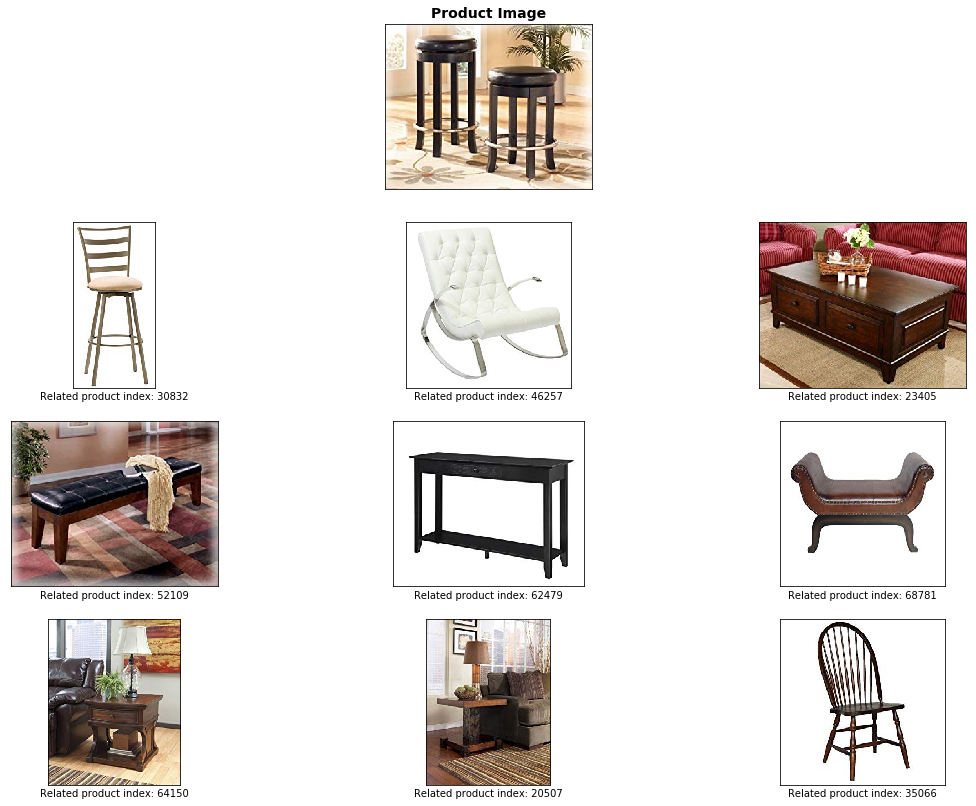

In [100]:
get_related_products(44003)

In [62]:
nums = [23405, 52109, 62479, 68781, 64150, 20507, 35066]

In [64]:
for j in nums:
    print(str(j) + ' ' + new_df['title'].loc[j] + '\n')

23405 Larchmont Lift Top Cocktail Table

52109 Larchmont Large Upholstered Dining Room Bench

62479 Convenience Concepts 8013081-BL American Heritage Hall Table with Drawer and Shelf, Black

68781 Faux Leather Vanity Stool (Brown) (26&quot;H x 36&quot;W x 16&quot;D)

64150 Devrik Contemporary Style Medium Brown Finish Square End Table With Drawer

20507 MediumBrown Square End Table by &quot;Famous Brand&quot; Furniture

35066 Carolina Classic Cottage  Windsor Chair, Chestnut



Wow, pretty diverse result. We got some items related to the dining room and some other not so convincing results. So what's really going on here? The product descriptions appear to be pretty big in length and are essentially paragraphs. This module was trained to find semantic relationships between regular length sentences. Hence, some performance is compromised here due to the length of the descriptions. Nevertheless, if we're looking at stools, we wouldn't mind checking out some of those chairs? The tables? I suppose not!

In [107]:
new_df['title'].loc[8891]

'(13x19) Forest (Path through Trees) Art Poster Print'

We have posters here!

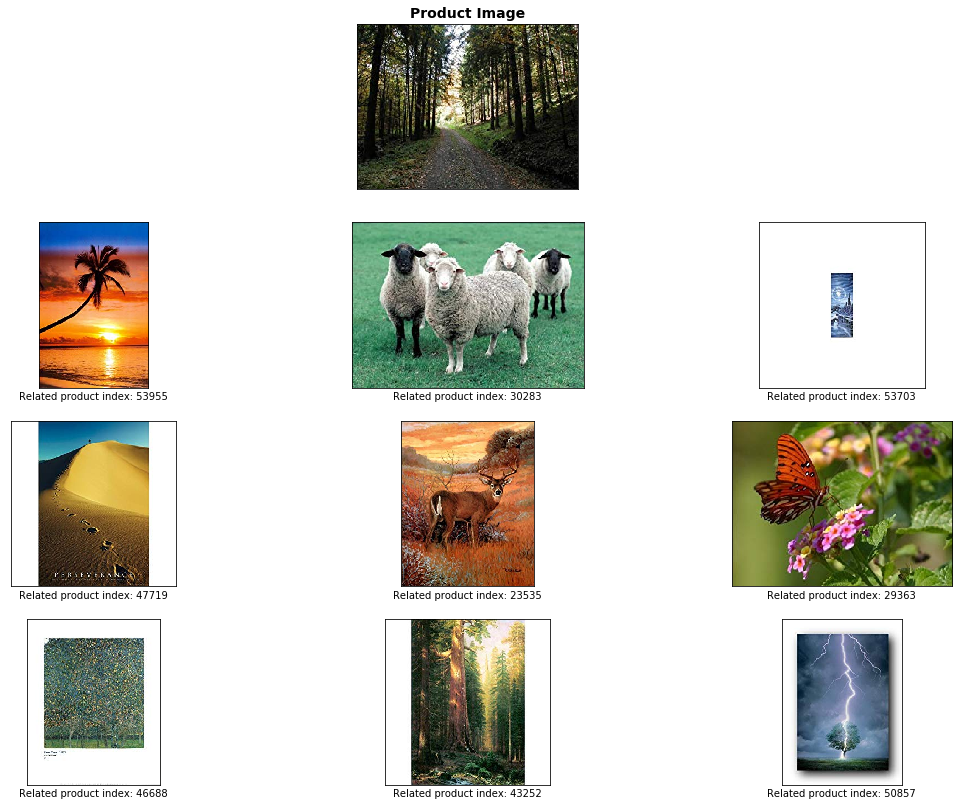

In [108]:
get_related_products(8891)

Sure we got posters back? But notice anything else? They all seem to be nature themed! That was the context here --> Nature themed wallpapers!

In [67]:
new_df['title'].loc[61429]

'InitTM - TV Stand for Most Flat-Panel TVs Up to 50&quot;'

We've got a TV stand here!

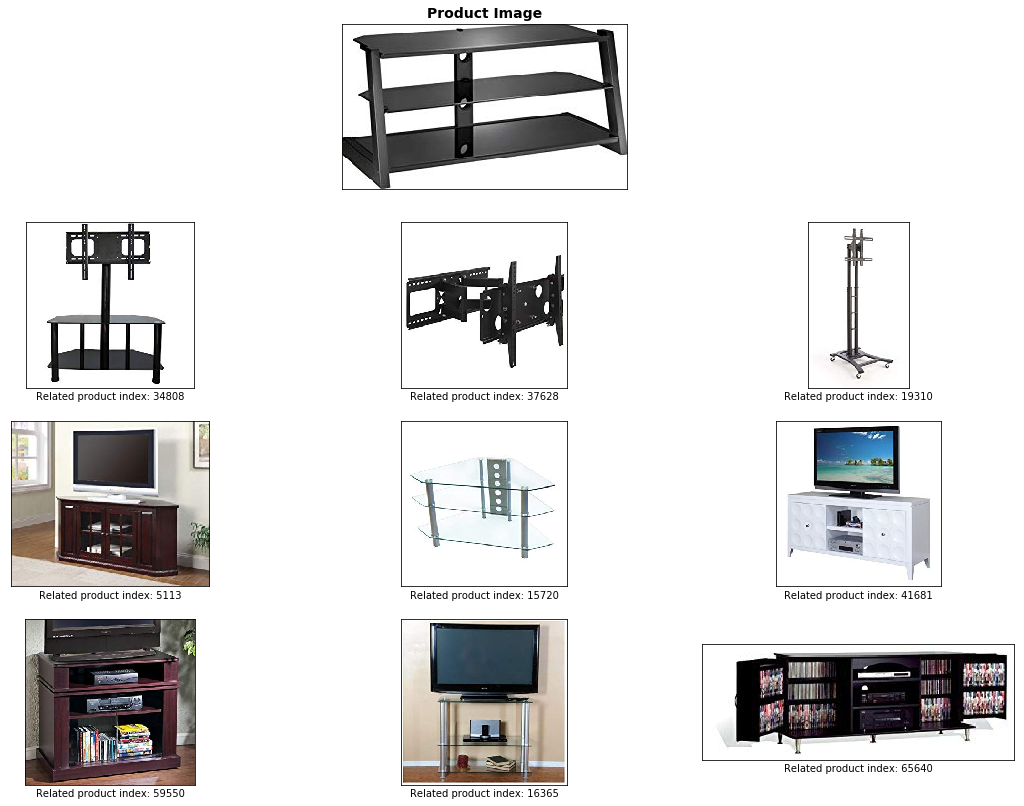

In [115]:
get_related_products(61429)

All TV stands! No surprises here!

In [68]:
new_df['title'].loc[60005]

'D2, Navy 1200 Series Bed Sheet Set King'

We've got king sized bed sheets.

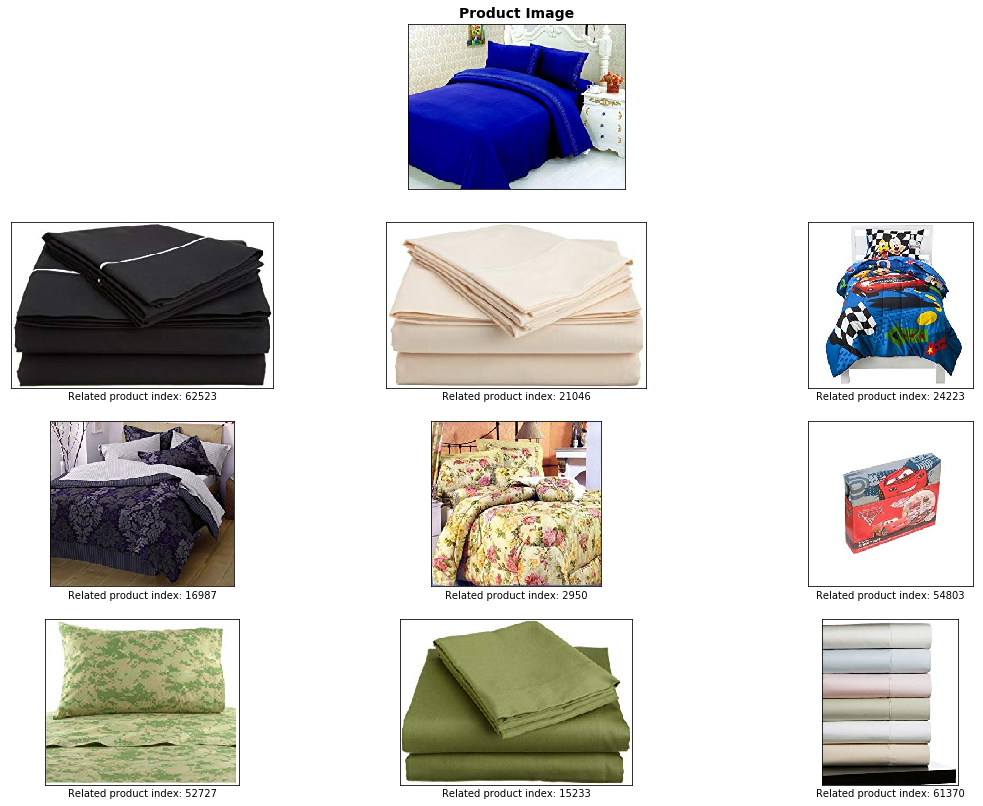

In [132]:
get_related_products(60005)

Once again, no surprises here!

In [69]:
new_df['title'].loc[60008]

'Glass Whistling Tea Kettle - 12 Cup'

We have a tea kettle here.

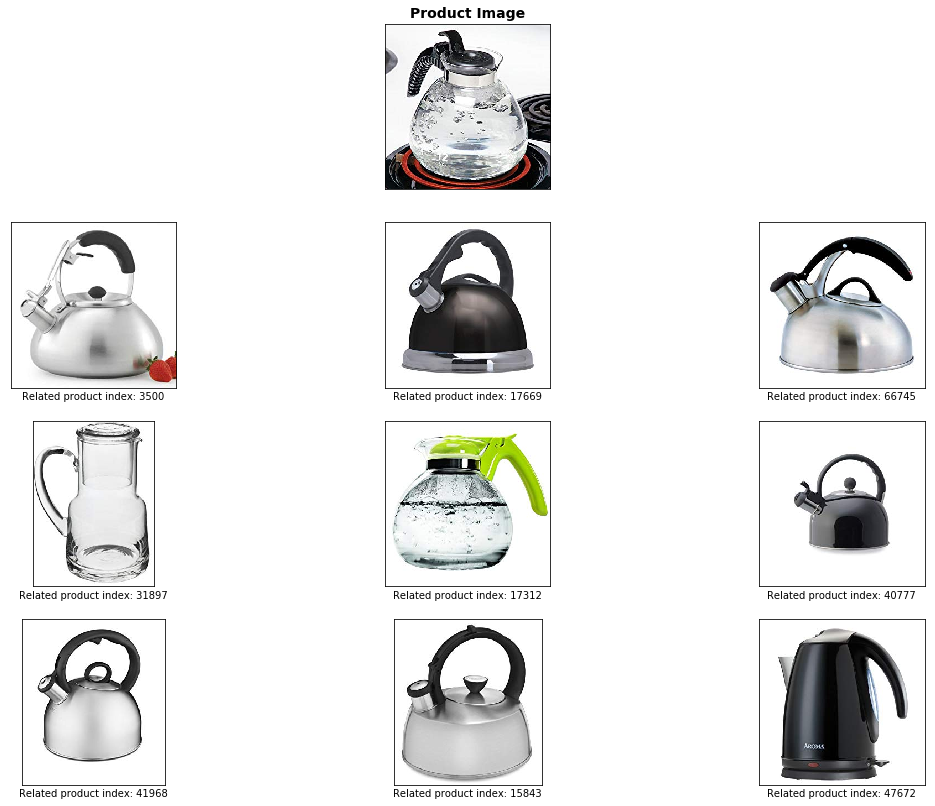

In [124]:
get_related_products(60008)

In [65]:
new_df['title'].loc[64702]

'381228-00 replacement glass blender jar. Fits Black &amp; Decker.'

We've got a glass blender jar.

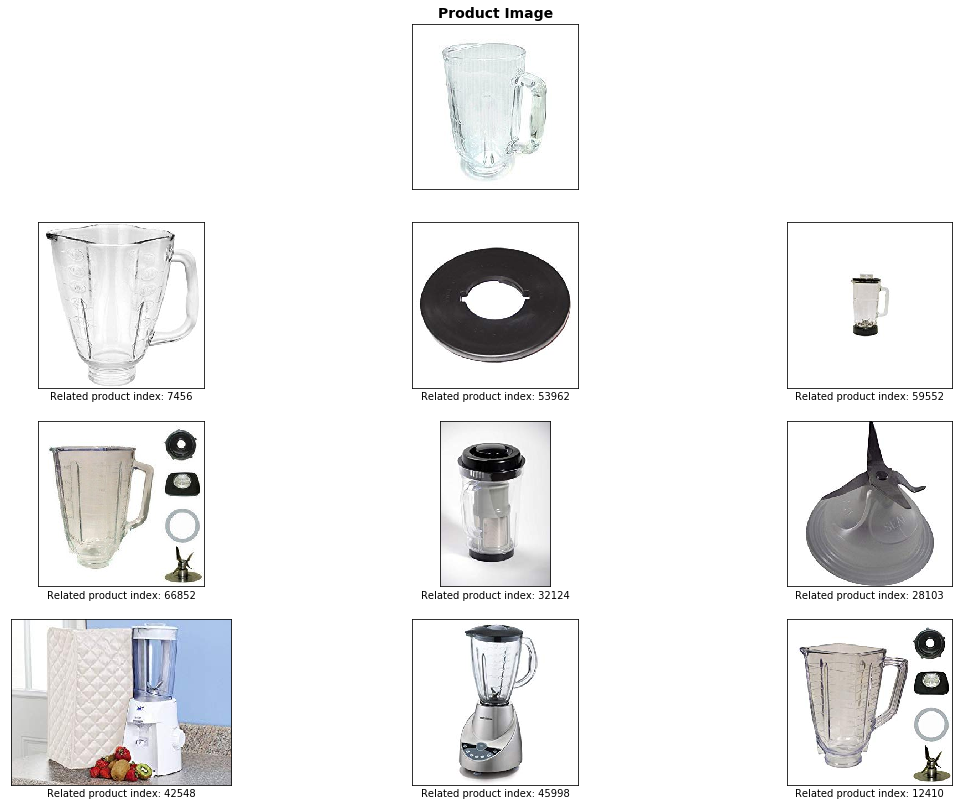

In [142]:
get_related_products(64702)

What we have are a some other blender parts and even some blenders.